In [1]:
#importing necessary libraries
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import rrcf

C:\Users\ANTARA\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<!-- # This script simulates a continuous data stream and introduces anomalies for anomaly detection testing.
# The data stream consists of three components: 
# - A linear baseline trend
# - A seasonal pattern modeled with a triangular wave
# - Random noise to mimic real-world variability

# Additionally, predefined anomalies are introduced into specific points of the data stream to simulate outliers.
# This code can be used for testing and evaluating anomaly detection algorithms.

# Functions:
# 1. generate_data_stream(): Generates the synthetic data stream with a combination of baseline, seasonality, and noise.
# 2. add_anomalies_to_data(): Modifies the generated data stream by injecting anomalies at specific indices. -->

#### Data Stream Simulation: 
This script simulates a synthetic data sequence and introduces random anomalies for anomaly detection testing.
The data sequence is composed of three main components:
1. A linear trend representing a regular increase in value over time.
2. A seasonal pattern modeled using a triangular wave to simulate periodic fluctuations.
3. Random noise added to the sequence to mimic real-world variations.

Additionally, the script provides functionality to inject random anomalies (both spikes and drops) into the sequence.
These anomalies can represent unexpected changes in the data, useful for testing anomaly detection algorithms.

Functions:
1. #### create_data_sequence(): 
Generates the data sequence by combining a linear trend, seasonal component, and random noise.
2. #### insert_anomalies(): 
Randomly inserts anomalies into the data sequence, either as sudden spikes or drops.

In [2]:
# Function to create a data stream with a linear trend, seasonality, and random noise
def create_data_sequence(sequence_length):
    try:
        # Validating if sequence_length is a positive integer
        if not isinstance(sequence_length, int) or sequence_length <= 0:
            raise ValueError("Sequence length must be a positive integer.")

        # Number of data points (sequence length)
        num_data_points = sequence_length
        # Creating a linear trend
        linear_trend = np.linspace(50, 150, num_data_points)
        
        # Adding seasonality using a triangular wave pattern
        cycle_period = 100  # Length of the cycle for seasonality
        seasonal_component = 20 * signal.sawtooth(2 * np.pi * np.arange(num_data_points) / cycle_period, 0.5)

        # Adding random noise
        noise_component = np.random.normal(0, 5, num_data_points)

        # Combine the trend, seasonality, and noise to form the final data sequence
        data_sequence = linear_trend + seasonal_component + noise_component
        
        return data_sequence

    except ValueError as e:
        print(f"Error in create_data_sequence: {e}")


# Function to insert anomalies into the data sequence
def insert_anomalies(data_sequence, num_anomalies=10):
    try:
        # Ensure the input is a NumPy array
        if not isinstance(data_sequence, np.ndarray):
            raise TypeError("Data sequence must be a NumPy array.")

        # Randomly select indices where anomalies will be introduced
        anomaly_positions = np.random.choice(len(data_sequence), size=num_anomalies, replace=False)
        
        # Insert anomalies: either a large spike or a sharp drop
        for pos in anomaly_positions:
            if np.random.rand() > 0.5:
                data_sequence[pos] += np.random.uniform(50, 100)  # spike
            else:
                data_sequence[pos] -= np.random.uniform(50, 100)  # drop

        return data_sequence

    except TypeError as e:
        print(f"Error in insert_anomalies: {e}")

#### Algorithm Selection
The following script implements a Random Cut Forest (RCF) for detecting anomalies in a data stream.
The RCF is composed of multiple Random Cut Trees (RCT), which are used to identify unusual patterns or outliers in a data sequence.

Key Features:
1. **Random Cut Forest (RCF) Construction**: The `RandomCutForest` class creates and manages a forest of RCTrees. The number of trees, tree capacity, and shingle length (window size) are defined by the user.
2. **Anomaly Detection**: The `detect_anomaly` method calculates the average displacement (codisplacement) for a given data point across all trees. Points with high displacement values are likely to be anomalies.
3. **Tree Management**: The trees have a maximum capacity, and the oldest points are forgotten once the capacity is exceeded, ensuring that the forest adapts to new data in a streaming environment.

This approach is efficient for detecting anomalies in real-time data streams and can handle both concept drift and evolving data patterns.



In [3]:

# Class to build and manage a Random Cut Tree (RCT) forest for anomaly detection
class RandomCutForest:
    def __init__(self, num_trees, tree_capacity, shingle_length):
        try:
            # Validate that all input parameters are positive integers
            if not all(isinstance(param, int) and param > 0 for param in [num_trees, tree_capacity, shingle_length]):
                raise ValueError("All parameters must be positive integers.")

            # Initialize the Random Cut Forest with a specified number of trees and tree capacity
            self.num_trees = num_trees
            self.tree_capacity = tree_capacity
            self.shingle_length = shingle_length

            # Create a list of RCTree instances to form the forest
            self.forest = [rrcf.RCTree() for _ in range(num_trees)]

        except ValueError as e:
            print(f"Error in initialization: {e}")

    # Method to detect anomalies based on a new data point
    def detect_anomaly(self, sequence_index, data_point):
        try:
            # Validate that sequence_index is a non-negative integer
            if not isinstance(sequence_index, int) or sequence_index < 0:
                raise ValueError("Sequence index must be a non-negative integer.")

            # Validate that data_point is a list of numeric values with the correct length
            if not isinstance(data_point, list) or len(data_point) != self.shingle_length or not all(isinstance(val, (int, float)) for val in data_point):
                raise ValueError(f"Data point must be a list of {self.shingle_length} numeric values.")

            # Initialize the average displacement to zero
            avg_displacement = 0

            for tree in self.forest:
                # If the tree size exceeds its capacity, forget the oldest data point (FIFO)
                if len(tree.leaves) > self.tree_capacity:
                    tree.forget_point(sequence_index - self.tree_capacity)

                # Insert the new data point into the tree
                tree.insert_point(data_point, index=sequence_index)

                # Calculate the displacement for the new point
                point_displacement = tree.codisp(sequence_index)

                # Accumulate the displacement across all trees
                avg_displacement += point_displacement / self.num_trees

            # Return the average displacement for the given data point
            return avg_displacement

        except ValueError as e:
            print(f"Error in anomaly detection: {e}")


#### Data Visualization
This code snippet generates a synthetic data sequence using a sinusoidal pattern, 
introduces anomalies to simulate real-world irregularities, and visualizes the 
resulting data sequence using Matplotlib.

Key Steps:
1. **Data Sequence Generation**: The `create_data_sequence` function generates a data sequence 
   of specified length (1000) with a sinusoidal pattern, a linear trend, and added noise.
2. **Anomaly Introduction**: The `insert_anomalies` function randomly adds anomalies 
   to the data sequence to mimic unexpected changes, such as spikes or drops.
3. **Data Visualization**: The resulting data sequence, including the introduced anomalies, 
   is plotted using Matplotlib for visual analysis.

This visualization helps in understanding the characteristics of the data sequence 
and the impact of anomalies on the overall data pattern.
"""


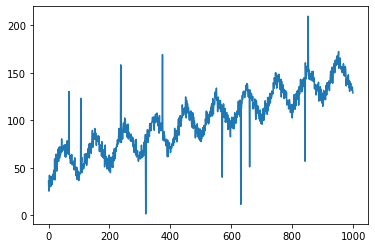

In [4]:
# Generates a data sequence with a sinusoidal pattern of length 1000
data_sequence = create_data_sequence(1000)

# Introduces anomalies to the generated data sequence
insert_anomalies(data_sequence)

# Plots the data sequence using Matplotlib
plt.plot(np.arange(1000), data_sequence)

plt.show()


#### Model Implementation
This code snippet initializes a Random Cut Forest (RCF) for anomaly detection in a data stream.

Key Steps:
1. **Tree Configuration**: 
   - The number of trees in the forest is set to 40 (`num_trees`).
   - The capacity limit for each tree, determining how many data points each tree can hold, is set to 256 (`tree_capacity`).
   - The size of the shingle (or window) used for data point insertion is defined as 4 (`shingle_length`).

2. **Forest Initialization**: 
   - An instance of the `RandomCutForest` class is created using the specified parameters. 
   - This forest will be used to detect anomalies in streaming data by managing multiple Random Cut Trees.

This setup is essential for preparing the anomaly detection system to analyze incoming data and identify unusual patterns effectively.



In [11]:
# Define the number of trees in the Random Cut Forest (RCF)
num_trees = 40

# Define the size limit for each tree in the Random Cut Forest
tree_capacity = 256

# Define the size of the shingle (window)
shingle_length = 4

# Create an instance of the RandomCutForest class with the specified number of trees and tree capacity
forest = RandomCutForest(num_trees, tree_capacity, shingle_length)

#### Anomaly Detection
This code snippet processes a data sequence to detect anomalies using the previously initialized 
Random Cut Forest (RCF). It utilizes a sliding window approach to evaluate data points in the sequence.

Key Steps:
1. **Initialization**: 
   - Empty lists are created to store the calculated anomaly scores (`anomaly_scores`) and maintain the current data window (`current_data_window`).
   - Additional variables (`previous_index` and `is_first_window`) are initialized for tracking purposes.

2. **Sliding Window Processing**: 
   - The code iterates through the data sequence, populating the initial window with data values for the first few indices.
   - Once the window is fully populated, it slides through the sequence, updating the current window with the latest data point while removing the oldest point.

3. **Anomaly Score Calculation**: 
   - For each updated window, the `detect_anomaly` method of the Random Cut Forest is called to calculate an anomaly score.
   - This score is appended to the list of anomaly scores.

4. **Anomaly Detection Logic**: 
   - A threshold is applied to identify sudden peaks in the anomaly score, indicating potential anomalies in the data stream.
   - If an anomaly is detected based on the defined criteri


In [12]:
# Initialize empty lists to store anomaly scores and the current data window
anomaly_scores = []
current_data_window = []
previous_index = 0
is_first_window = True

# Iterate through the data sequence
for current_index in range(len(data_sequence)):
    # If the index is within the shingle size, populate the initial window with data_sequence values
    if current_index < forest.shingle_length:
        current_data_window.append(data_sequence[current_index])
        # Initialize anomaly score to 0 for the initial window
        anomaly_scores.append(0)
        continue
    else:
        # Update the current data window by adding the latest data_sequence value and removing the oldest
        current_data_window.append(data_sequence[current_index])
        current_data_window = current_data_window[1:]

    # Calculate anomaly score using the Random Cut Forest for the current window
    score = forest.detect_anomaly(current_index, current_data_window)

    # Append the calculated anomaly score to the list
    anomaly_scores.append(score)

    # If there is a sudden peak, we can say it is an anomaly
    if current_index > forest.shingle_length + 1 and (score >= 2 * anomaly_scores[current_index - 1] or score <= -1.7 * anomaly_scores[current_index - 1]): 
        print("Anomaly Detected at index_no: ", current_index)


Anomaly Detected at index_no:  43
Anomaly Detected at index_no:  61
Anomaly Detected at index_no:  67
Anomaly Detected at index_no:  106
Anomaly Detected at index_no:  144
Anomaly Detected at index_no:  184
Anomaly Detected at index_no:  231
Anomaly Detected at index_no:  237
Anomaly Detected at index_no:  278
Anomaly Detected at index_no:  281
Anomaly Detected at index_no:  287
Anomaly Detected at index_no:  305
Anomaly Detected at index_no:  318
Anomaly Detected at index_no:  319
Anomaly Detected at index_no:  324
Anomaly Detected at index_no:  341
Anomaly Detected at index_no:  374
Anomaly Detected at index_no:  439
Anomaly Detected at index_no:  465
Anomaly Detected at index_no:  473
Anomaly Detected at index_no:  482
Anomaly Detected at index_no:  489
Anomaly Detected at index_no:  547
Anomaly Detected at index_no:  570
Anomaly Detected at index_no:  589
Anomaly Detected at index_no:  631
Anomaly Detected at index_no:  654
Anomaly Detected at index_no:  660
Anomaly Detected at ind

#### Data Visualisation after Anomaly Detection
This code snippet visualizes the original data sequence and the corresponding anomaly scores using Matplotlib.

Key Steps:
1. **Data Visualization**: 
   - The original data sequence (`data_sequence`) is plotted as a line graph, labeled 'Data Sequence'.
   - The calculated anomaly scores (`anomaly_scores`) are plotted on the same graph in red, labeled 'Anomaly Score'.

2. **Plot Display**: 
   - The final plot is displayed, allowing for visual analysis of the data and any anomalies identified throughout the sequence.

This visualization is essential for understanding the behavior of the data stream and the effectiveness of the anomaly detection mechanism.
"""


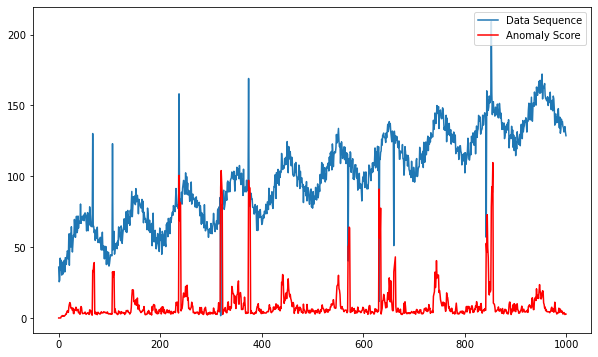

In [15]:
plt.figure(figsize=(10, 6))

# Plot the original data sequence using Matplotlib
plt.plot(np.arange(1000), data_sequence, label='Data Sequence')

# Plot the calculated anomaly scores using Matplotlib
plt.plot(np.arange(1000), anomaly_scores, label='Anomaly Score', color='red')

plt.legend(loc='upper right')
plt.show()


#### Why Robust Random Cut Forest Algorithm has been Used?

1. **Robustness to Concept Drift**: RRCF is designed to be robust in the presence of concept drift, which refers to changes in the underlying data distribution over time. The randomization and ensemble nature of the algorithm enable it to adapt to shifting patterns in the data.  

2. **Adaptibility to Seasonal Variation**:  The algorithm's ability to construct a forest of trees allows it to adapt to different patterns, including those associated with regular cycles or trends.  